<a href="https://colab.research.google.com/github/adel-nouar/ML_with_Rune/blob/main/10%20-%20Project%20-%20Recurrent%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Reucurrent Neural Network
- A project on weather predictin on time series data

### Step 1: Import libraries

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
%matplotlib inline

### Step 2: Download dataset
- Excute the cell below

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


### Step 3: Read the data
- Use Pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method to read **csv_path** (from step 2).
    - Also **parse_dates=True** and **index_col=0**

In [3]:
data = pd.read_csv(csv_path, parse_dates=True, index_col=0)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
len(data)

420551

### Step 4: Limit dataset
- The dataset has metrics for every 10 minutes - we will limit it to only once per hour
    - HINT: **data[5::6]** will start at 5 and step 6.
        - **a[start:stop:step]** start through not past stop, by step

In [5]:
data = data[5::6]

In [6]:
len(data)

70091

In [7]:
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


### Step 5: Investigate data
- Call **corr()** on the data to see correlations
- Inspect what columns are correlated and not

In [8]:
data.corr()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.045296,-0.124643,-0.066698,-0.018363,-0.031455,-0.054353,-0.003283,-0.069749,-0.069792,0.307583,-0.005740,-0.007360,-0.063678
T (degC),-0.045296,1.000000,0.996826,0.895706,-0.572593,0.951080,0.867691,0.761672,0.866770,0.867195,-0.963404,-0.004923,-0.003884,0.041577
Tpot (K),-0.124643,0.996826,1.000000,0.894909,-0.567306,0.947259,0.866228,0.756886,0.866553,0.866978,-0.981342,-0.004426,-0.003263,0.046465
Tdew (degC),-0.066698,0.895706,0.894909,1.000000,-0.156834,0.799182,0.968361,0.435689,0.967614,0.968061,-0.885231,-0.008581,-0.009693,0.052507
rh (%),-0.018363,-0.572593,-0.567306,-0.156834,1.000000,-0.616019,-0.151704,-0.843768,-0.151049,-0.151181,0.514461,-0.004227,-0.008641,-0.017297
VPmax (mbar),-0.031455,0.951080,0.947259,0.799182,-0.616019,1.000000,0.824758,0.875639,0.824349,0.824386,-0.901488,-0.004358,-0.003154,-0.006787
VPact (mbar),-0.054353,0.867691,0.866228,0.968361,-0.151704,0.824758,1.000000,0.449080,0.999851,0.999856,-0.850271,-0.009390,-0.010883,0.020988
VPdef (mbar),-0.003283,0.761672,0.756886,0.435689,-0.843768,0.875639,0.449080,1.000000,0.448561,0.448615,-0.698195,0.001138,0.004315,-0.028644
sh (g/kg),-0.069749,0.866770,0.866553,0.967614,-0.151049,0.824349,0.999851,0.448561,1.000000,0.999997,-0.853354,-0.009270,-0.010736,0.021961
H2OC (mmol/mol),-0.069792,0.867195,0.866978,0.968061,-0.151181,0.824386,0.999856,0.448615,0.999997,1.000000,-0.853801,-0.009272,-0.010736,0.022195


### Step 6: Remove data
- Potential some data could be transformed **'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'**
    - We will ignorre it

In [10]:
df = data.drop(['wv (m/s)', 'max. wv (m/s)', 'wd (deg)'], axis=1)

### Step 7: Add periodic time intervals
- Temperature is correlated to the time of day - e.g. it is warmer at mid day than at mid night
- Temperature is correlated to seasons (most places in the world) - e.g. it is warmer in summer than in winter
- The datetime index is not easy for the model to interpret, hence we can transform it into sinus and cosinus curves based on day and year.
- Do it like this
    - Assign the dataframe index to a variable, say, **timestamp_s**
    - Transform that by using **map(pd.Timestamp.timestamp)**
    - Use the period **day =** $24\times 60 \times 60$ and **year =** $(365.2425)\times$**day**
    - Make the following columns **'Day sin', 'Day cos', 'Year sin'**, and **'Year cos'** as follows:
        - e.g. **df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))**

In [16]:
timestamp_s = df.index
timestamp_s = timestamp_s.map(pd.Timestamp.timestamp)

In [17]:
timestamp_s

Float64Index([1230771600.0, 1230775200.0, 1230778800.0, 1230782400.0,
              1230786000.0, 1230789600.0, 1230793200.0, 1230796800.0,
              1230800400.0, 1230804000.0,
              ...
              1483193400.0, 1483197000.0, 1483200600.0, 1483204200.0,
              1483207800.0, 1483211400.0, 1483215000.0, 1483218600.0,
              1483222200.0, 1483225800.0],
             dtype='float64', name='Date Time', length=70091)

In [18]:
df.index

DatetimeIndex(['2009-01-01 01:00:00', '2009-01-01 02:00:00',
               '2009-01-01 03:00:00', '2009-01-01 04:00:00',
               '2009-01-01 05:00:00', '2009-01-01 06:00:00',
               '2009-01-01 07:00:00', '2009-01-01 08:00:00',
               '2009-01-01 09:00:00', '2009-01-01 10:00:00',
               ...
               '2016-12-31 14:10:00', '2016-12-31 15:10:00',
               '2016-12-31 16:10:00', '2016-12-31 17:10:00',
               '2016-12-31 18:10:00', '2016-12-31 19:10:00',
               '2016-12-31 20:10:00', '2016-12-31 21:10:00',
               '2016-12-31 22:10:00', '2016-12-31 23:10:00'],
              dtype='datetime64[ns]', name='Date Time', length=70091, freq=None)

In [14]:
day = 24 * 60 * 60
year = (365.2425) * day

In [19]:
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [20]:
df.corr()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Day sin,Day cos,Year sin,Year cos
p (mbar),1.000000,-0.045296,-0.124643,-0.066698,-0.018363,-0.031455,-0.054353,-0.003283,-0.069749,-0.069792,0.307583,0.024335,0.004076,-0.056380,0.019768
T (degC),-0.045296,1.000000,0.996826,0.895706,-0.572593,0.951080,0.867691,0.761672,0.866770,0.867195,-0.963404,-0.209414,-0.158552,-0.142263,-0.462367
Tpot (K),-0.124643,0.996826,1.000000,0.894909,-0.567306,0.947259,0.866228,0.756886,0.866553,0.866978,-0.981342,-0.209994,-0.157833,-0.136772,-0.460871
Tdew (degC),-0.066698,0.895706,0.894909,1.000000,-0.156834,0.799182,0.968361,0.435689,0.967614,0.968061,-0.885231,-0.042241,-0.021313,-0.216200,-0.430777
rh (%),-0.018363,-0.572593,-0.567306,-0.156834,1.000000,-0.616019,-0.151704,-0.843768,-0.151049,-0.151181,0.514461,0.393867,0.312590,-0.088733,0.242826
VPmax (mbar),-0.031455,0.951080,0.947259,0.799182,-0.616019,1.000000,0.824758,0.875639,0.824349,0.824386,-0.901488,-0.230615,-0.185214,-0.131800,-0.433101
VPact (mbar),-0.054353,0.867691,0.866228,0.968361,-0.151704,0.824758,1.000000,0.449080,0.999851,0.999856,-0.850271,-0.040985,-0.023096,-0.214678,-0.439461
VPdef (mbar),-0.003283,0.761672,0.756886,0.435689,-0.843768,0.875639,0.449080,1.000000,0.448561,0.448615,-0.698195,-0.329381,-0.272917,-0.024901,-0.308988
sh (g/kg),-0.069749,0.866770,0.866553,0.967614,-0.151049,0.824349,0.999851,0.448561,1.000000,0.999997,-0.853354,-0.041465,-0.023153,-0.213249,-0.439367
H2OC (mmol/mol),-0.069792,0.867195,0.866978,0.968061,-0.151181,0.824386,0.999856,0.448615,0.999997,1.000000,-0.853801,-0.041463,-0.023142,-0.213366,-0.439501


### Step 8: Splitting data

#### About splitting
If you want to build a solid model you have to follow that specific protocol of splitting your data into three sets: One for training, one for validation and one for final evaluation, which is the test set.

The idea is that you train on your training data and tune your model with the results of metrics (accuracy, loss etc) that you get from your validation set.

Your model doesn't "see" your validation set and isn't in any way trained on it, but you as the architect and master of the hyperparameters tune the model according to this data. Therefore it indirectly influences your model because it directly influences your design decisions. You nudge your model to work well with the validation data and that can possibly bring in a tilt.

#### What to do?
- Use the length of data and split it into
    - 70% for training
    - 20% for validation
    - 10% for testing set

In [23]:
nb_elts = len(df)
train_df = df[:int(nb_elts * .7)]
val_df = df[int(nb_elts * .7):int(nb_elts *.9)]
test_df = df[int(nb_elts * .9):]

### Step 9: Normalize data
- Only normalize data based on training data
    - Notice you should only normalize the training data - because validation and test data could affect the normalization
- Get the mean and standard deviation of the data
    - HINT: Use **.mean()** and **.std()** on the dataframe.
- Noramlize the data as follows
    - **train_df = (train_df - train_mean) / train_std** (assuming naming fits)
    - HINT: The transformation of validation and test data is done similarly with **train_mean** and **train_std**.

In [25]:
train_mean = train_df.mean()
train_std = train_df.std()

In [26]:
train_df = (train_df - train_mean) / train_std 
val_df = (val_df - train_mean) / train_std 
test_df = (test_df - train_mean) / train_std 

### Step 10: Create datasets
<img src='https://github.com/adel-nouar/ML_with_Rune/blob/main/img/data_windowing.png?raw=1' width=600 align='left'>

- Make a function with **input_width** and **offset** - assume we always use **label_width=1**.
- Call the function **create_dataset**, which takes arguments **df, input_width=24, offset=0, predict_column='T (degC)'**
    - Let it create two empty lists **x** and **y**
    - Convert the dataframe **df** to numpy and assign it to **data_x**
    - Do the same for the **predict_column** but assign it to **data_y**
    - Iterate over the range of starting from **input_width** to **len(data_x) - offset**
        - Append to **x** with **data_x[i-input_width:i,:]**
        - Append to **y** with **data_y[i + offset]**
    - Convert **x** and **y** to numpy arrays
        - HINT: Use **np.array(...)**
    - Return the **x** and **y** (but reshape y with **reshape(-1, 1)**)
- Apply the function on training, validation, and test data

In [30]:
def create_dataset(df, input_width:int=24, offset:int=0, predict_column:str='T (degC)'):
  x = []
  y = []
  data_x = df.to_numpy()
  data_y = df[predict_column].to_numpy()

  for i in range(input_width, len(data_x) - offset ):
    x.append(data_x[i - input_width:i, :])
    y.append(data_y[i + offset])
  
  x = np.array(x)
  y = np.array(y)

  return x, y.reshape(-1, 1)

In [31]:
train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

In [32]:
train_ds[0].shape

(49039, 24, 15)

### Step 11: Create model
- Create the following model
    - **model = models.Sequential()**
    - **model.add(layers.LSTM(32, return_sequences=True, input_shape=train_ds[0].shape[1:]))**
    - **model.add(layers.Dense(units=1))**

In [33]:
model = models.Sequential()
model.add(layers.LSTM(32, return_sequences=True, input_shape=train_ds[0].shape[1:]))
model.add(layers.Dense(units=1))

### Step 12: Train model
- Compile and fit the model
- Complie the model as follows
    - **model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])**
- Fit the model as follows
    - **model.fit(x=train_ds[0], y=train_ds[1], validation_data=(val_ds[0], val_ds[1]), epochs=5)**

In [34]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(x=train_ds[0], y=train_ds[1], validation_data=(val_ds[0], val_ds[1]), epochs=10)

Epoch 1/10
1533/1533 [==============================] - 21s 12ms/step - loss: 0.1188 - accuracy: 0.0000e+00 - val_loss: 0.0947 - val_accuracy: 0.0000e+00
Epoch 2/10
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0873 - accuracy: 0.0000e+00 - val_loss: 0.0897 - val_accuracy: 0.0000e+00
Epoch 3/10
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0837 - accuracy: 0.0000e+00 - val_loss: 0.0881 - val_accuracy: 0.0000e+00
Epoch 4/10
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0818 - accuracy: 0.0000e+00 - val_loss: 0.0860 - val_accuracy: 0.0000e+00
Epoch 5/10
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0803 - accuracy: 0.0000e+00 - val_loss: 0.0871 - val_accuracy: 0.0000e+00
Epoch 6/10
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0795 - accuracy: 0.0000e+00 - val_loss: 0.0842 - val_accuracy: 0.0000e+00
Epoch 7/10
1533/1533 [==============================] - 19s 12ms/step - loss

### Step 13: Predict data
- Apply the model on the test data
    - HINT: Use **model.predict(x)**, where **x** is assigned to the test data.

In [35]:
x, y = test_ds

In [36]:
y_pred = model.predict(x)

In [37]:
y_pred.shape

(6986, 24, 1)

### Step 14: Plot the result
- Plot a window of the data predicted together with the actual data.
- One way:
    - **fig, ax = plt.subplots()**
    - **ax.plot(y[i:i+96*2,0], c='g')**
    - **ax.plot(pred[i:i+96*2,-1,0], c='r')**
- It will plot a window of 96 hours, where you can index with **i** (**i=150** as an example) and **y** is the real values and **pred** are the predicted values

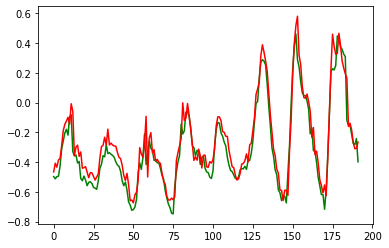

In [38]:
fig, ax = plt.subplots()
i = 200
ax.plot(y[i:i+96*2,0], c='g')
ax.plot(y_pred[i:i+96*2,-1,0], c='r')

### Step 15 (Optional): Calculate the correlation
- Create a dataframe with real and predicted values.
- Apply the **.corr()** method on the dataframe.

In [41]:
df_c = pd.DataFrame({'real': y[:,0], 'pred': y_pred[:, -1,0]})

df_c.corr()

,real,pred
real,1.000000,0.992758
pred,0.992758,1.000000
